<table style="width:100%; border:none;">
  <tr>
    <td style="width:150px; text-align:center; vertical-align:middle;">
      <img src="https://upload.wikimedia.org/wikipedia/en/6/69/Seal_of_Pablo_de_Olavide_University.png" 
           alt="Emblema UPO" 
           style="width:130px; margin:10px;">
    </td>
    <td style="text-align:center; vertical-align:middle;">
      <h2 style="margin-bottom:5px;">Universidad Pablo de Olavide</h2>
      <p><strong>Grado en Ingeniería Informática en Sistemas de Información</strong></p>
      <p><strong>Asignatura: Inteligencia Artificial</strong></p>
      <p><strong>Curso 2025/2026</strong></p>
      <h3 style="margin-top:10px;">TRABAJO #1 – Equipo 08</h3>
      <h4 style="margin-top:5px;">Dataset asignado: Nº 17</h4>
      <p><strong>Integrantes:</strong> María Pérula Gutiérrez &nbsp;·&nbsp; Jonathan Javier Quishpe Maldonado</p>
      <p><strong>Fecha de entrega:</strong> 01/12/2025</p>
    </td>
  </tr>
</table>

<hr style="margin-top:25px; margin-bottom:25px; border: 1px solid #bbb;">
<h2 style="text-align:center;">Regresión Logística - Implementación</h2>

In [1]:
# REGRESIÓN LOGÍSTICA => Coche para estudiante

# Aquí usaremos la regresión logística para separar los coches de nuestro dataset en dos grupos:
#   1 -> coche recomendable para un estudiante universitario
#   0 -> coche que no lo es
#
# Para decidir qué coche es bueno para estudiante nos hemos guiado por caracteristicas de un alumno medio de universidad:
#   - que no sea muy caro,
#   - que gaste poco (economy alta),
#   - que no esté en muy mal estado para no tener muchas averias (condition decente)
#
# Por lo que definiremos una variable binaria (estudiante_ok), y como variables de entrada: price, km, economy, condition y rating. A partir de ahí aplicaremos exactamente
# el esquema de regresión logística de la EPD 3

### 1. Importaciones y lectura del dataset

In [2]:
import pandas as pd
import numpy as np
import scipy.optimize as op
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("train.csv")
df = df.rename(columns={"current price": "price"})

In [4]:
#Creamos la variable binaria de estudiante_ok
precio_medio = df["price"].mean()

df["estudiante_ok"] = ((df["economy"] >= 8) & (df["condition"] >= 3) & (df["price"] <= precio_medio)).astype(int)

print("Primeras filas + estudiante_ok:\n")
print(df[["price", "km", "economy", "condition", "rating", "estudiante_ok"]].head())

Primeras filas + estudiante_ok:

      price      km  economy  condition  rating  estudiante_ok
0  351318.0   78945       14          2       1              0
1  285001.5  117220        9          9       5              1
2  215386.0  132538       15          8       2              1
3  244295.5  101065       11          3       4              1
4  531114.5   61559       12          9       3              0


### 2. Variables de entrada X y la clase y | Normalización de características

In [5]:
columnas_X = ["price", "km", "economy", "condition", "rating"]
#X = df[columnas_X].copy()
X_full = df[columnas_X].copy()
y_full = df[["estudiante_ok"]].copy()

#Normalizamos porque nos sale "overflow encountered in exp" en punto "6. Theta, coste y gradiente iniciales"
def featureNormalize(X):
    media = X.mean()
    desv = X.std()
    X_norm = (X - media) / desv
    return X_norm, media, desv

X_norm, media_log, desv_log = featureNormalize(X_full)

unos = np.ones(len(X_norm))
X = X_norm.copy()
X.insert(0, "ones", unos)

print("\nShape de X:", X.shape)
print("Shape de y:", y_full.shape)


Shape de X: (1000, 6)
Shape de y: (1000, 1)


### 3. Función sigmoide

In [6]:
def sigmoid(z):
    # Clipear z para evitar overflow en exp(-z)
    # Cuando z es muy grande (>500), exp(-z) -> 0, entonces sigmoid -> 1
    # Cuando z es muy pequeño (<-500), exp(-z) -> infinito, entonces sigmoid -> 0
    z = np.clip(z, -500, 500)
    denominador = 1 + np.exp(-z)
    g = 1 / denominador
    return g

### 4. Función coste (vectorizada)

In [7]:
def costFunction(theta, X, y):
    m = len(y)
    Xn = X.values # m,n
    yn = y # yn vector de 1D
    z = Xn.dot(theta) # m
    
    h = sigmoid(z) #m
   #Evitamos el log(0) ya que nha encontrado valores 0 o 1 en "6. Theta, coste y gradiente iniciales"
    eps = 1e-8
    h = np.clip(h, eps, 1 - eps)
    
    termino1 = yn * np.log(h)
    termino2 = (1 - yn) * np.log(1 - h)

    J = (-1/m) * np.sum(termino1 + termino2)
    return J

### 5. Función gradiente (vectorizada)

In [8]:
def gradientFunction(theta, X, y_vec):
    m = len(y_vec)
    Xn = X.values
    z = Xn.dot(theta)
    h = sigmoid(z)
    grad = (1/m) * (Xn.T.dot(h - y_vec)) # n
    return grad

### 6. Función predicción

In [9]:
def predict(theta, X, bool_round=True):
    Xn = X.values
    z = Xn.dot(theta)
    probs = sigmoid(z)
    if bool_round:
        return np.round(probs)
    else:
        return probs

### 7. Validación cruzada - 10 repeticiones (90%/10%)

In [10]:

np.random.seed(0) #mismos splits

alpha = 0.01 #fmin_cg hace su propio paso, este alpha no se usa aqui
maxiter = 400 #nmax iteraciones fmin_cg
n_reps = 10 #10 particiones

accuracy_list = []
TP_list, TN_list, FP_list, FN_list = [], [], [], []

theta_opt_main = None
media_main = None
desv_main = None
cost_history_main = None

for rep in range(n_reps):
    m = len(X_full)
    idx = np.random.permutation(m)
    train_size = int(0.9 * m)

    #90% train, 10% test -> recomendado por la profesora porque no tenemos muchisimos datos
    idx_train = idx[:train_size]
    idx_test  = idx[train_size:]

    X_train_raw = X_full.iloc[idx_train].copy()
    y_train = y_full.iloc[idx_train].copy() #(m_train,1)

    X_test_raw = X_full.iloc[idx_test].copy()
    y_test = y_full.iloc[idx_test].copy()

    #Normalizamos SOLO estadisticas train
    X_train_norm, media, desv = featureNormalize(X_train_raw)
    X_test_norm = (X_test_raw - media) / desv

    #print("DEBUG: tamaño de X_train:", X_train_norm.shape)

    #Añadimos columna de unos
    X_train_norm.insert(0, "ones", 1)
    X_test_norm.insert(0, "ones", 1)

    # heta inicial a ceros (igual que en EPD)
    theta_ini = np.zeros(X_train_norm.shape[1])
    y_train_vec = y_train.to_numpy().flatten()

    #print(theta_ini)

    #Guardar historia de coste solo para esta rep.
    cost_history_rep = []
    def guardar_coste_log(theta_actual):
        c = costFunction(theta_actual, X_train_norm, y_train_vec)
        cost_history_rep.append(c)

    #Entrenamos solo con conjunto de entrenamiento
    theta_opt = op.fmin_cg(
        f=costFunction,
        x0=theta_ini,
        fprime=gradientFunction,
        args=(X_train_norm, y_train_vec),
        maxiter=maxiter,
        callback=guardar_coste_log,
        disp=False # para que no saque todo el log en cada rep.
    )

    #print(theta_opt)

    #Guardamos PRIMERA repetición para dibujar la gráfica y usar como modelo
    if rep == 0:
        theta_opt_main = theta_opt
        media_main = media
        desv_main = desv
        cost_history_main = cost_history_rep

    #Prediccion en el conjunto de test
    y_pred_test = predict(theta_opt, X_test_norm, bool_round=True).astype(int)
    y_test_vec = y_test.to_numpy().flatten()

    #Métricas en test
    accuracy = np.mean(y_pred_test == y_test_vec)
    TP = np.sum((y_test_vec == 1) & (y_pred_test == 1))
    TN = np.sum((y_test_vec == 0) & (y_pred_test == 0))
    FP = np.sum((y_test_vec == 0) & (y_pred_test == 1))
    FN = np.sum((y_test_vec == 1) & (y_pred_test == 0))

    accuracy_list.append(accuracy)
    TP_list.append(TP); TN_list.append(TN); FP_list.append(FP); FN_list.append(FN)

    print(f"Repetición {rep+1} / Accuracy test = {accuracy:.3f}  (TP={TP}, TN={TN}, FP={FP}, FN={FN})")

print("\nMEDIA de las 10 repeticiones (TEST):")
print("Accuracy medio :", np.mean(accuracy_list))
print("TP medio       :", np.mean(TP_list))
print("TN medio       :", np.mean(TN_list))
print("FP medio       :", np.mean(FP_list))
print("FN medio       :", np.mean(FN_list))

#Trabajamos con modelo de la primera repetición (gráficas, ejemplo...)
theta_opt = theta_opt_main
media_log = media_main
desv_log = desv_main
cost_history_log = cost_history_main

Repetición 1 / Accuracy test = 0.850  (TP=28, TN=57, FP=8, FN=7)
Repetición 2 / Accuracy test = 0.890  (TP=27, TN=62, FP=2, FN=9)
Repetición 3 / Accuracy test = 0.870  (TP=27, TN=60, FP=7, FN=6)
Repetición 4 / Accuracy test = 0.880  (TP=32, TN=56, FP=8, FN=4)


Repetición 5 / Accuracy test = 0.840  (TP=37, TN=47, FP=8, FN=8)
Repetición 6 / Accuracy test = 0.860  (TP=30, TN=56, FP=5, FN=9)
Repetición 7 / Accuracy test = 0.850  (TP=35, TN=50, FP=6, FN=9)
Repetición 8 / Accuracy test = 0.850  (TP=28, TN=57, FP=6, FN=9)
Repetición 9 / Accuracy test = 0.870  (TP=33, TN=54, FP=7, FN=6)
Repetición 10 / Accuracy test = 0.850  (TP=28, TN=57, FP=4, FN=11)

MEDIA de las 10 repeticiones (TEST):
Accuracy medio : 0.8610000000000001
TP medio       : 30.5
TN medio       : 55.6
FP medio       : 6.1
FN medio       : 7.8


### 8. Theta, coste y gradiente iniciales

In [11]:
n_param = X.shape[1]
theta_ini = np.zeros(n_param) #vector 1D
y_vec = y_full.to_numpy().flatten() #m

print("\nCoste inicial con theta (0): ", costFunction(theta_ini, X, y_vec))
print("Gradiente inicial: \n", gradientFunction(theta_ini, X, y_vec))

#Para la gráfica
cost_history_log = []
def guardar_coste_log(theta):
    c = costFunction(theta, X, y_vec)
    cost_history_log.append(c)

# Optimizacion fmin_cg
theta_opt = op.fmin_cg(
    f = costFunction,
    x0 = theta_ini,
    fprime = gradientFunction,
    args = (X, y_vec),
    maxiter = 400,
    callback = guardar_coste_log
)

print("\nTheta optimo:")
print(theta_opt)


Coste inicial con theta (0):  0.6931471805599454
Gradiente inicial: 
 [ 0.092       0.3397436  -0.33782546 -0.01927776 -0.09611219  0.0307273 ]
Optimization terminated successfully.
         Current function value: 0.289499
         Iterations: 20
         Function evaluations: 63
         Gradient evaluations: 63

Theta optimo:
[-1.04196569 -3.10130639  0.22287657  0.03599764  1.41479513 -0.19275264]


### 9. Gráfica de convergencia

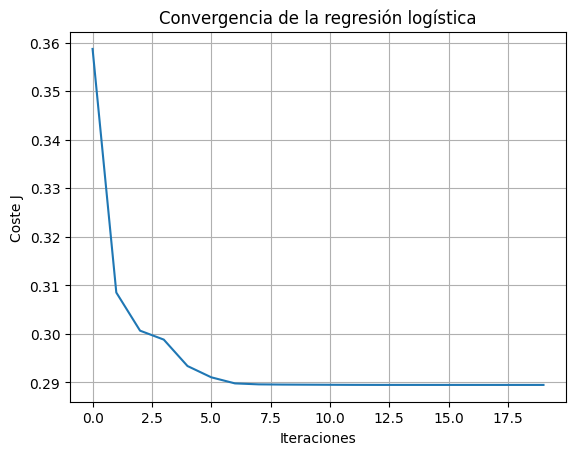

In [12]:
plt.plot(cost_history_log)
plt.xlabel("Iteraciones")
plt.ylabel("Coste J")
plt.title("Convergencia de la regresión logística")
plt.grid(True)
plt.show()

### 10. Predicciones

In [13]:
def predict(theta, X, bool_round=True):
    Xn = X.values
    z = Xn.dot(theta)
    probs = sigmoid(z)
    if bool_round:
        return np.round(probs)
    else:
        return probs

# Necesitamos: Coche barato, con pocos km, que tenga buena economía con una condición decente y un rating medio aceptable
# Valores seleccionados [price, km, economy, condition, rating]
ejemplo_coche_raw = [200000, 50000, 9, 4, 4]

# Normalizamos usando media/desviación qdel entrenamiento
ejemplo_norm = (np.array(ejemplo_coche_raw) - media_log.values) / desv_log.values

# Añadimos el 1 inicial
fila_ejemplo = np.insert(ejemplo_norm, 0, 1)  # [1, price, km, economy, condition, rating]

df_ejemplo = pd.DataFrame([fila_ejemplo], columns=X.columns)

ej_prob = predict(theta_opt, df_ejemplo, bool_round=False)
ej_clase = predict(theta_opt, df_ejemplo, bool_round=True)

print("\nEjemplo de coche para estudiante:")
print("Características originales (sin normalizar):", ejemplo_coche_raw)
print("Probabilidad de ser 'estudiante_ok':", float(ej_prob[0]))
print("Predicción (0/1):", int(ej_clase[0]))


Ejemplo de coche para estudiante:
Características originales (sin normalizar): [200000, 50000, 9, 4, 4]
Probabilidad de ser 'estudiante_ok': 0.5459667515108496
Predicción (0/1): 1


### 11. Evaluación usando TODO el dataset

In [14]:
X_full_norm = (X_full - media_log) / desv_log
X_full_norm.insert(0, "ones", 1)

y_pred_full = predict(theta_opt, X_full_norm, bool_round=True).astype(int)
y_real_full = y_full.to_numpy().flatten()

accuracy_full = np.mean(y_pred_full == y_real_full)
print("\nAccuracy del modelo sobre TODO el dataset:", accuracy_full)

TP = np.sum((y_real_full == 1) & (y_pred_full == 1))
TN = np.sum((y_real_full == 0) & (y_pred_full == 0))
FP = np.sum((y_real_full == 0) & (y_pred_full == 1))
FN = np.sum((y_real_full == 1) & (y_pred_full == 0))

print("\nMatriz de confusión (todo el dataset):")
print("TP (1 bien predicho):", TP)
print("TN (0 bien predicho):", TN)
print("FP (0 mal como 1)   :", FP)
print("FN (1 mal como 0)   :", FN)


Accuracy del modelo sobre TODO el dataset: 0.856

Matriz de confusión (todo el dataset):
TP (1 bien predicho): 329
TN (0 bien predicho): 527
FP (0 mal como 1)   : 65
FN (1 mal como 0)   : 79


In [15]:
# Conclusiones: El modelo de regresión logística para estudiante_ok da un accuracy de 0.85 (85%), acierta aproximadamente 8 de cada 10 coches, que está bastante bien
# para las 5 variables que usamos.
#
# La matriz de confusión muestra que acierta bastantes ok y no ok, aunque hay algunos coches buenos que descarta y otros que sobrevalora, algo típico en este modelo sencillo.
#
# Viendo las gráficas de price vs economy, tanto los datos reales como las predicciones siguen la idea que teníamos: los coches más baratos y con mejor
# economía son los que salen como buenos para un estudiante.

### 12. Gráfica price vs economy (real vs predicho)

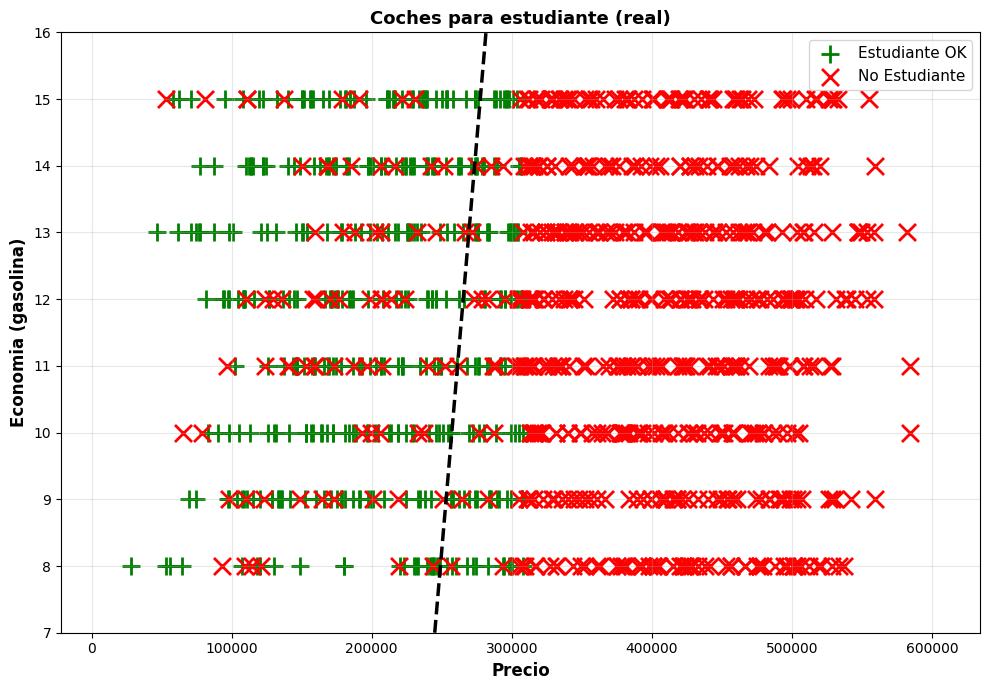

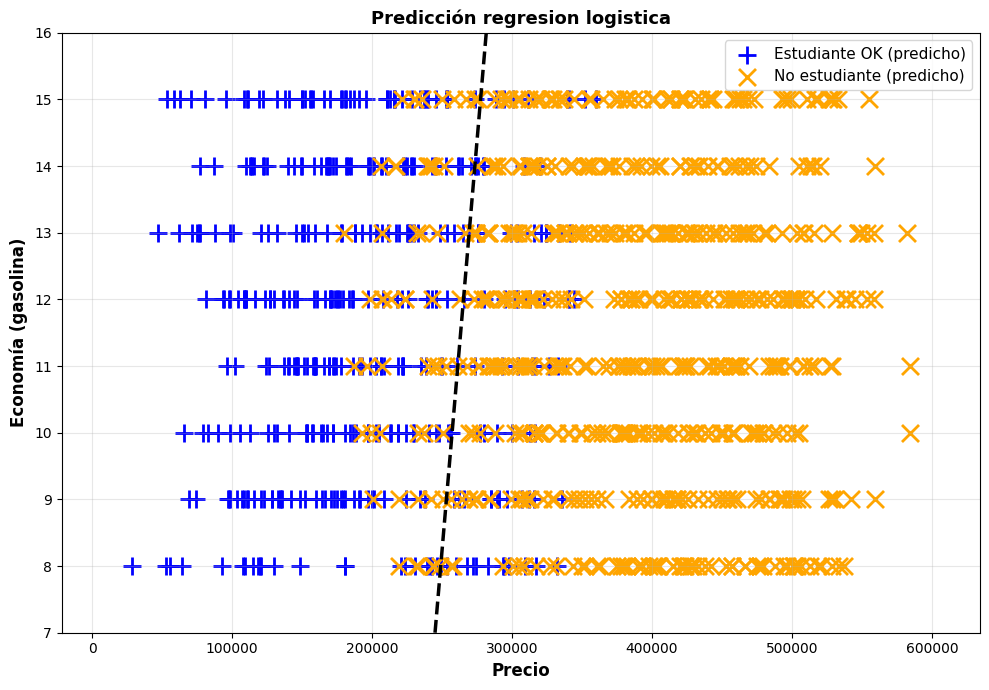

In [ ]:
# En nuestro caso estamos usando 5 variables para saber si un coche es apropiado para un estudiante medio, pero como no se puede dibujar en 5D,
# hemos pensado en observar estas gráficas con dos variables bastante significativas en este caso: price y economy.
# Un estudiante principalmente (según nuestro criterio), se fija en estas dos opciones.

import matplotlib.pyplot as plt

# Dibujamos los puntos reales segun la clase
def plot_estudiante_real(df):
    
    df_ok = df[df["estudiante_ok"] == 1]
    df_no = df[df["estudiante_ok"] == 0]

    # Crear malla para frontera de decisión
    min_price, max_price = df["price"].min() - 50000, df["price"].max() + 50000
    min_econ, max_econ = df["economy"].min() - 1, df["economy"].max() + 1
    
    xx, yy = np.meshgrid(np.linspace(min_price, max_price, 200),
                         np.linspace(min_econ, max_econ, 200))
    
    # Crear features normalizadas para la malla 
    points_flat = np.column_stack([xx.ravel(), yy.ravel()])
    points_norm = np.column_stack([
        (points_flat[:, 0] - media_log['price']) / desv_log['price'],
        (points_flat[:, 1] - media_log['economy']) / desv_log['economy']
    ])
    # Otros features en 0 (normalizados)
    points_full = np.column_stack([
        np.ones(points_norm.shape[0]),
        points_norm[:, 0],
        points_norm[:, 1],
        np.zeros(points_norm.shape[0]),  # km normalizado = 0
        np.zeros(points_norm.shape[0]),  # condition normalizado = 0
        np.zeros(points_norm.shape[0])   # rating normalizado = 0
    ])
    Z_flat = sigmoid(points_full.dot(theta_opt))
    Z = Z_flat.reshape(xx.shape)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Frontera de decisión
    ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2.5, linestyles='--')
    
    # Puntos dispersos
    ax.scatter(df_ok["price"], df_ok["economy"], c="g", marker="+", s=150, label="Estudiante OK", linewidths=2)
    ax.scatter(df_no["price"], df_no["economy"], c="r", marker="x", s=150, label="No Estudiante", linewidths=2)

    ax.set_xlabel("Precio", fontsize=12, fontweight='bold')
    ax.set_ylabel("Economia (gasolina)", fontsize=12, fontweight='bold')
    ax.set_title("Coches para estudiante (real)", fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# Dibujamos lo que predice nuestra regresion logistica
def plot_estudiante_pred(df_clasif):
    
    df_ok = df_clasif[df_clasif["pred_clase"] == 1]
    df_no = df_clasif[df_clasif["pred_clase"] == 0]

    # Crear malla para frontera de decisión
    min_price, max_price = df_clasif["price"].min() - 50000, df_clasif["price"].max() + 50000
    min_econ, max_econ = df_clasif["economy"].min() - 1, df_clasif["economy"].max() + 1
    
    xx, yy = np.meshgrid(np.linspace(min_price, max_price, 200),
                         np.linspace(min_econ, max_econ, 200))
    
    # Crear features normalizadas para la malla
    points_flat = np.column_stack([xx.ravel(), yy.ravel()])
    points_norm = np.column_stack([
        (points_flat[:, 0] - media_log['price']) / desv_log['price'],
        (points_flat[:, 1] - media_log['economy']) / desv_log['economy']
    ])
    # Otros features en 0 (normalizados)
    points_full = np.column_stack([
        np.ones(points_norm.shape[0]),
        points_norm[:, 0],
        points_norm[:, 1],
        np.zeros(points_norm.shape[0]),  # km normalizado = 0
        np.zeros(points_norm.shape[0]),  # condition normalizado = 0
        np.zeros(points_norm.shape[0])   # rating normalizado = 0
    ])
    Z_flat = sigmoid(points_full.dot(theta_opt))
    Z = Z_flat.reshape(xx.shape)
    
    fig, ax = plt.subplots(figsize=(10, 7))

    
    # Frontera de decisión
    ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2.5, linestyles='--')
    
    # Puntos dispersos
    ax.scatter(df_ok["price"], df_ok["economy"], c="b", marker="+", s=150, label="Estudiante OK (predicho)", linewidths=2)
    ax.scatter(df_no["price"], df_no["economy"], c="orange", marker="x", s=150, label="No estudiante (predicho)", linewidths=2)

    ax.set_xlabel("Precio", fontsize=12, fontweight='bold')
    ax.set_ylabel("Economía (gasolina)", fontsize=12, fontweight='bold')
    ax.set_title("Predicción regresion logistica", fontsize=13, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# Clasificamos el dataset con el modelo aprendido
pred_clase = predict(theta_opt, X, bool_round=True)

df_clasificado = df.copy()
df_clasificado["pred_clase"] = pred_clase

# Gráfica del real
plot_estudiante_real(df)

# Gráfica del predicho
df_clasificado_plot = df_clasificado.copy()
df_clasificado_plot["price"] = df["price"]
df_clasificado_plot["economy"] = df["economy"]

plot_estudiante_pred(df_clasificado_plot)

# Conclusión: En la gráfica real los coches marcados como estudiante_ok están sobre todo en la zona de precio bajo y economía baja.
# En la grafica de predicción se ve un patrón parecido: el modelo tiende a marcar como buenos para estudiante los coches más baratos, aunque hay algunos puntos que se escapan en la economía (gasto medio gasolina)
# Para ser un modelo sencillo con 5 variables, la tasa de acierto es razonable (85%).

### 10. ANÁLISIS UNIVARIABLE - Modelos con Pares de Variables

**Objetivo de esta sección:**
En esta sección entrenaremos modelos de regresión logística usando pares de variables para identificar qué combinación de características discrimina mejor entre las clases (coche recomendable vs no recomendable para estudiante).

**Teoría: Por qué analizar pares de variables**

El análisis univariable con pares de variables es una técnica exploratoria fundamental:

- **Interpretabilidad**: Modelos con 2 variables son visualizables en 2D, permitiendo entender la frontera de decisión
- **Identificación de relaciones**: Revela qué parejas de características son más discriminativas para la clasificación
- **Reducción de dimensionalidad**: Algunos modelos simples pueden ser tan efectivos como el modelo completo (5 variables)
- **Estudio de interacciones**: Permite observar cómo dos variables conjuntas modelan el comportamiento de la clase objetivo
- **Diagnóstico**: Ayuda a detectar multicolinealidad y redundancia entre variables

**Metodología:**

Generaremos todas las combinaciones posibles de 2 variables a partir de nuestro conjunto de características: `price`, `km`, `economy`, `condition` y `rating`. Para cada par:

1. Entrenaremos un modelo independiente de regresión logística
2. Evaluaremos su rendimiento usando métricas: Accuracy, Precisión, Recall y F1-Score
3. Visualizaremos la frontera de decisión para interpretar el modelo
4. Compararemos resultados para identificar el par más discriminativo

Este análisis nos permitirá entender cuáles son las combinaciones de características más importantes para clasificar un coche como adecuado para un estudiante.

In [17]:
from itertools import combinations

# Seleccionamos 6 variables para hacer análisis por pares
variables_analisis = ["price", "km", "economy", "condition", "rating"]

# Generamos todas las combinaciones de 2 variables
pares_variables = list(combinations(variables_analisis, 2))
print(f"Pares de variables a analizar: {len(pares_variables)}")
print("\nCombinaciones generadas:")
for i, par in enumerate(pares_variables, 1):
    print(f"  {i}. {par[0]} vs {par[1]}")

# Diccionario para guardar resultados
resultados_modelos = {}


Pares de variables a analizar: 10

Combinaciones generadas:
  1. price vs km
  2. price vs economy
  3. price vs condition
  4. price vs rating
  5. km vs economy
  6. km vs condition
  7. km vs rating
  8. economy vs condition
  9. economy vs rating
  10. condition vs rating


#### 10.1 Función para entrenar modelo con un par de variables


In [18]:
def entrenar_modelo_par(X_par, y, nombre_par):
    """Entrena un modelo de regresión logística con un par de variables"""
    
    # Normalizamos
    X_norm, media, desv = featureNormalize(X_par)
    
    # Añadimos columna de unos
    unos = np.ones(len(X_norm))
    X_modelo = X_norm.copy()
    X_modelo.insert(0, "ones", unos)
    
    # Inicializamos theta
    n_param = X_modelo.shape[1]
    theta_ini = np.zeros(n_param)
    y_vec = y.to_numpy().flatten()
    
    # Optimización
    theta_opt = op.fmin_cg(
        f=costFunction,
        x0=theta_ini,
        fprime=gradientFunction,
        args=(X_modelo, y_vec),
        maxiter=400,
        disp=False
    )
    
    # Predicciones
    y_pred = predict(theta_opt, X_modelo, bool_round=True)
    
    # Evaluación
    accuracy = np.mean(y_pred == y_vec)
    
    # Matriz de confusión
    TP = np.sum((y_vec == 1) & (y_pred == 1))
    TN = np.sum((y_vec == 0) & (y_pred == 0))
    FP = np.sum((y_vec == 0) & (y_pred == 1))
    FN = np.sum((y_vec == 1) & (y_pred == 0))
    
    # Calculamos métricas adicionales
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'theta': theta_opt,
        'X_modelo': X_modelo,
        'accuracy': accuracy,
        'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'media': media,
        'desv': desv
    }


In [19]:
# Entrenamos modelos para cada par
print("\n" + "="*60)
print("ENTRENANDO MODELOS POR PARES DE VARIABLES")
print("="*60)

for par in pares_variables:
    var1, var2 = par
    print(f"\nEntrenando modelo: {var1} x {var2}")
    
    X_par = df[[var1, var2]].copy()
    modelo = entrenar_modelo_par(X_par, y_full, par)
    
    resultados_modelos[par] = modelo
    
    print(f"  Accuracy: {modelo['accuracy']:.4f}")
    print(f"  Precisión: {modelo['precision']:.4f}")
    print(f"  Recall: {modelo['recall']:.4f}")
    print(f"  F1-Score: {modelo['f1']:.4f}")
    print(f"  Matriz confusión -> TP:{modelo['TP']}, TN:{modelo['TN']}, FP:{modelo['FP']}, FN:{modelo['FN']}")



ENTRENANDO MODELOS POR PARES DE VARIABLES

Entrenando modelo: price x km
  Accuracy: 0.8460
  Precisión: 0.8128
  Recall: 0.8088
  F1-Score: 0.8108
  Matriz confusión -> TP:330, TN:516, FP:76, FN:78

Entrenando modelo: price x economy
  Accuracy: 0.8370
  Precisión: 0.8101
  Recall: 0.7843
  F1-Score: 0.7970
  Matriz confusión -> TP:320, TN:517, FP:75, FN:88

Entrenando modelo: price x condition
  Accuracy: 0.8540
  Precisión: 0.8243
  Recall: 0.8162
  F1-Score: 0.8202
  Matriz confusión -> TP:333, TN:521, FP:71, FN:75

Entrenando modelo: price x rating
  Accuracy: 0.8450
  Precisión: 0.8123
  Recall: 0.8064
  F1-Score: 0.8093
  Matriz confusión -> TP:329, TN:516, FP:76, FN:79

Entrenando modelo: km x economy
  Accuracy: 0.8440
  Precisión: 0.8043
  Recall: 0.8162
  F1-Score: 0.8102
  Matriz confusión -> TP:333, TN:511, FP:81, FN:75

Entrenando modelo: km x condition
  Accuracy: 0.8470
  Precisión: 0.8133
  Recall: 0.8113
  F1-Score: 0.8123
  Matriz confusión -> TP:331, TN:516, FP:76,

#### 10.2 Tabla resumen de rendimiento


In [20]:
print("\n" + "="*80)
print("TABLA RESUMEN - RENDIMIENTO DE MODELOS")
print("="*80)

resultados_df = []
for par, modelo in resultados_modelos.items():
    resultados_df.append({
        'Variables': f"{par[0]} vs {par[1]}",
        'Accuracy': modelo['accuracy'],
        'Precisión': modelo['precision'],
        'Recall': modelo['recall'],
        'F1-Score': modelo['f1']
    })

tabla_resumen = pd.DataFrame(resultados_df)
print(tabla_resumen.to_string(index=False))

# Identificar mejor modelo
mejor_par = max(resultados_modelos.items(), key=lambda x: x[1]['accuracy'])
print(f"\nMEJOR PAR DE VARIABLES (por Accuracy): {mejor_par[0]}")
print(f"  Accuracy: {mejor_par[1]['accuracy']:.4f}")



TABLA RESUMEN - RENDIMIENTO DE MODELOS
           Variables  Accuracy  Precisión   Recall  F1-Score
         price vs km     0.846   0.812808 0.808824  0.810811
    price vs economy     0.837   0.810127 0.784314  0.797011
  price vs condition     0.854   0.824257 0.816176  0.820197
     price vs rating     0.845   0.812346 0.806373  0.809348
       km vs economy     0.844   0.804348 0.816176  0.810219
     km vs condition     0.847   0.813268 0.811275  0.812270
        km vs rating     0.840   0.799517 0.811275  0.805353
economy vs condition     0.549   0.407725 0.232843  0.296412
   economy vs rating     0.592   0.000000 0.000000  0.000000
 condition vs rating     0.548   0.409091 0.242647  0.304615

MEJOR PAR DE VARIABLES (por Accuracy): ('price', 'condition')
  Accuracy: 0.8540


#### 10.3 Visualización de fronteras de decisión para cada par



VISUALIZACIÓN DE FRONTERAS DE DECISIÓN

Graficando: price vs km
    Frontera graficada correctamente


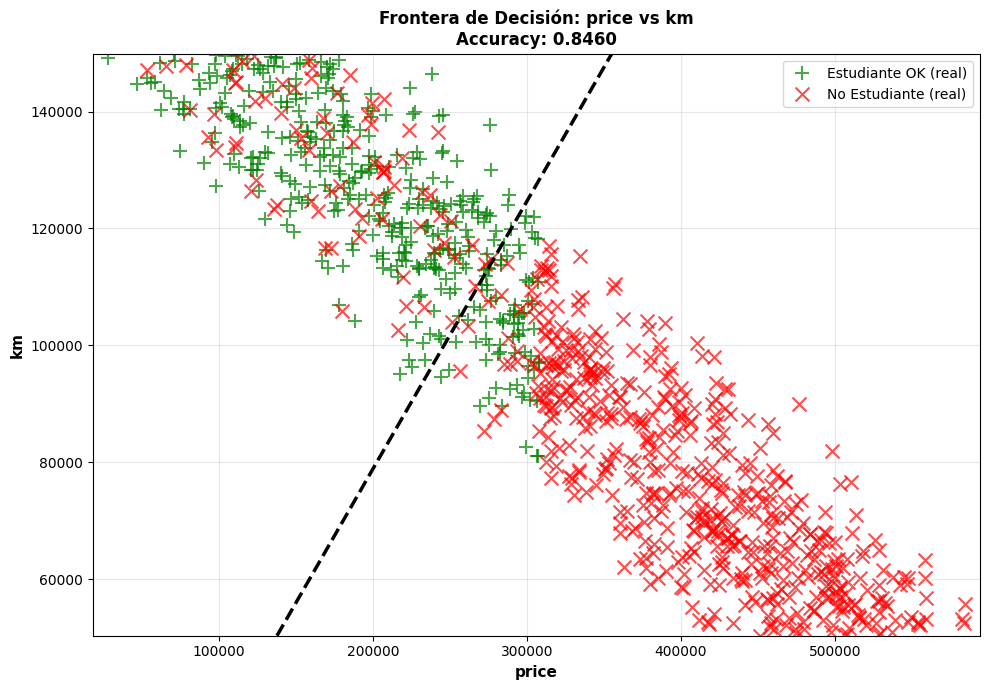


Graficando: price vs economy
    Frontera graficada correctamente


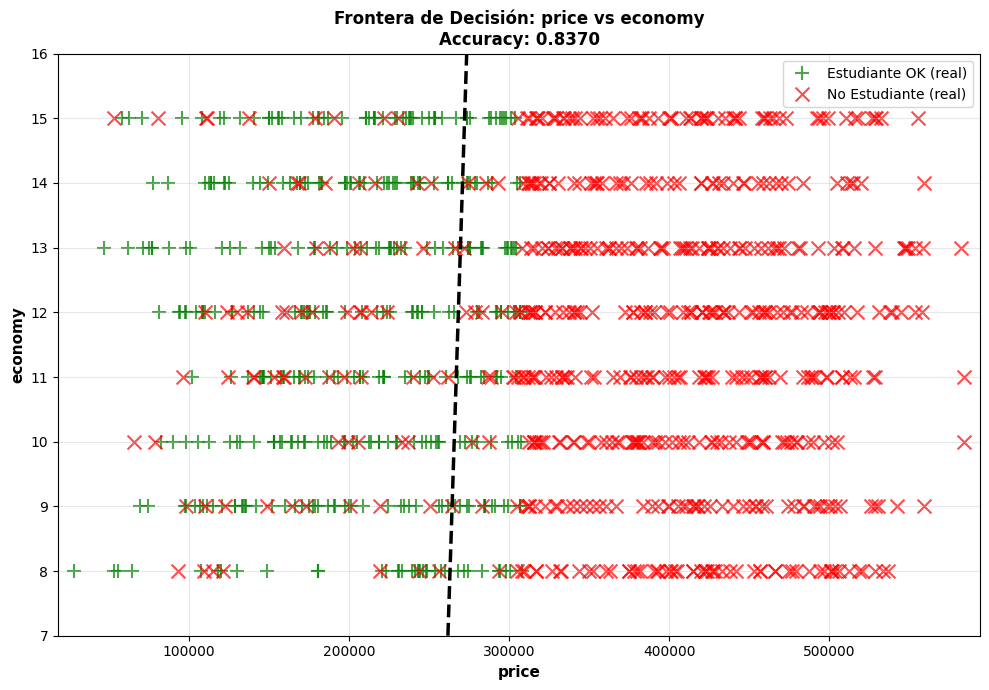


Graficando: price vs condition
    Frontera graficada correctamente


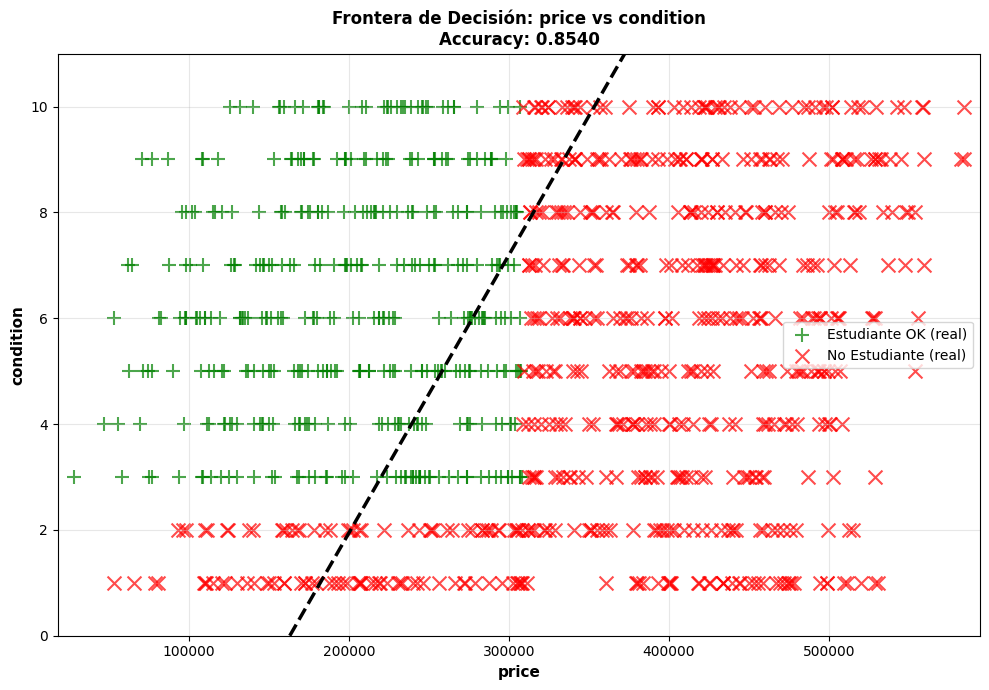


Graficando: price vs rating
    Frontera graficada correctamente


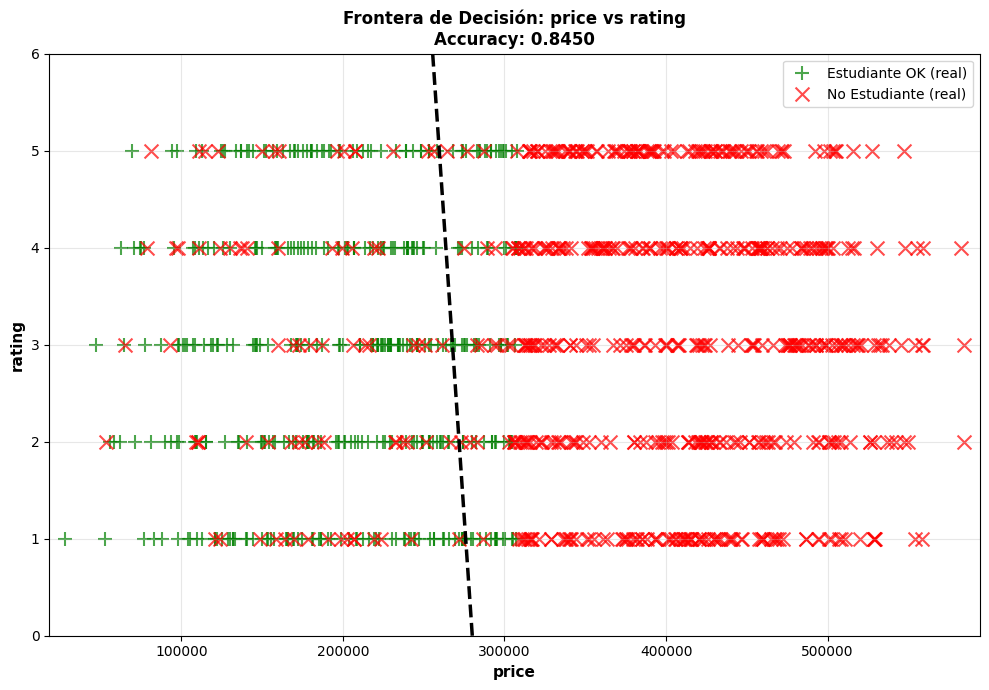


Graficando: km vs economy
    Frontera graficada correctamente


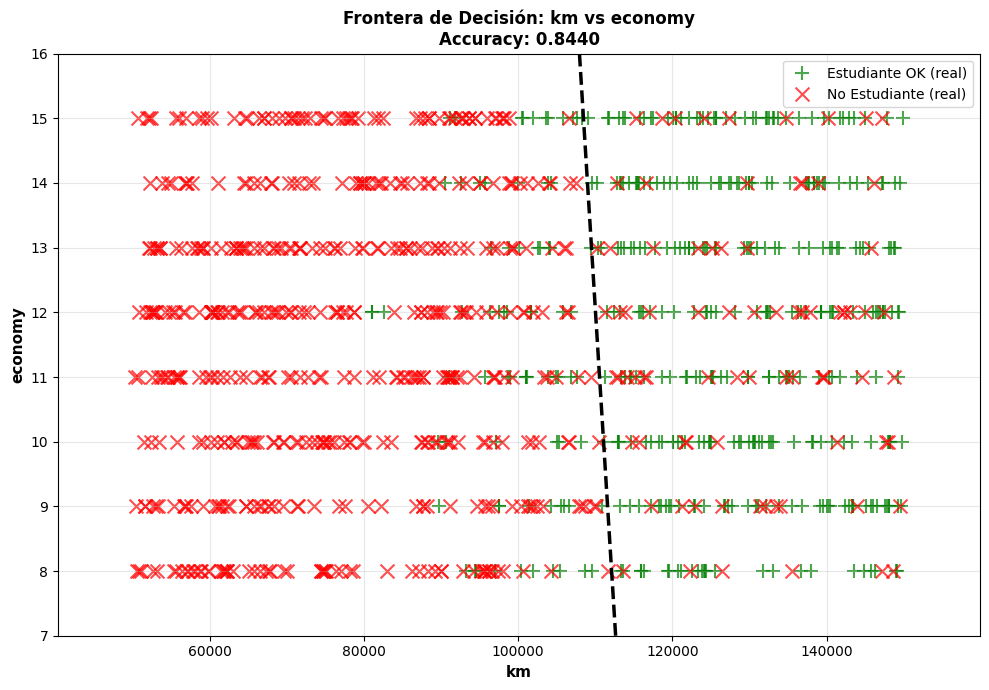


Graficando: km vs condition
    Frontera graficada correctamente


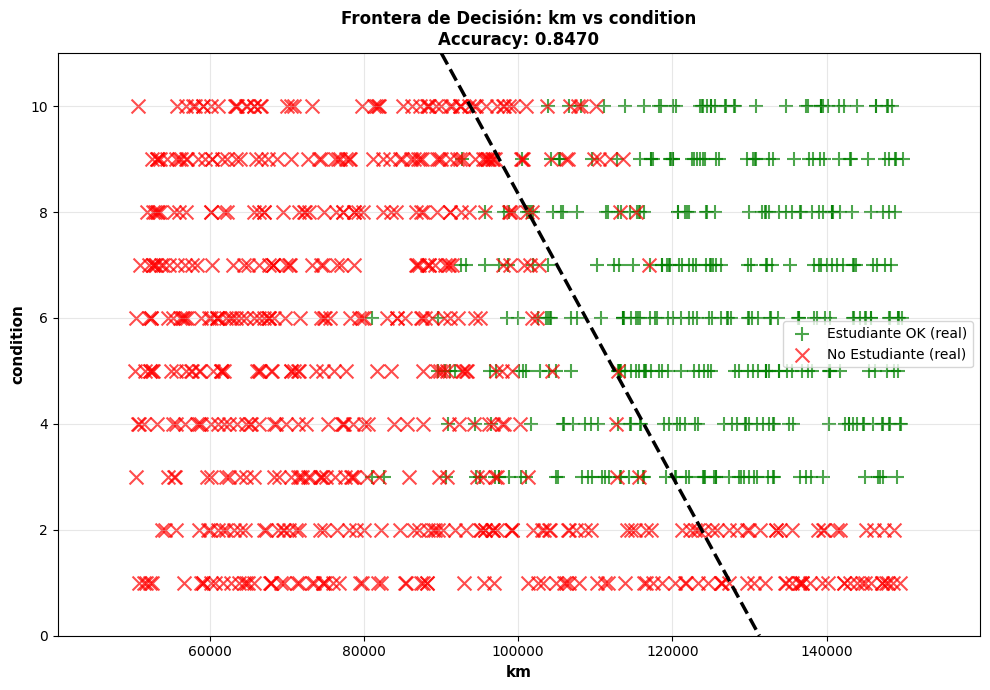


Graficando: km vs rating
    Frontera graficada correctamente


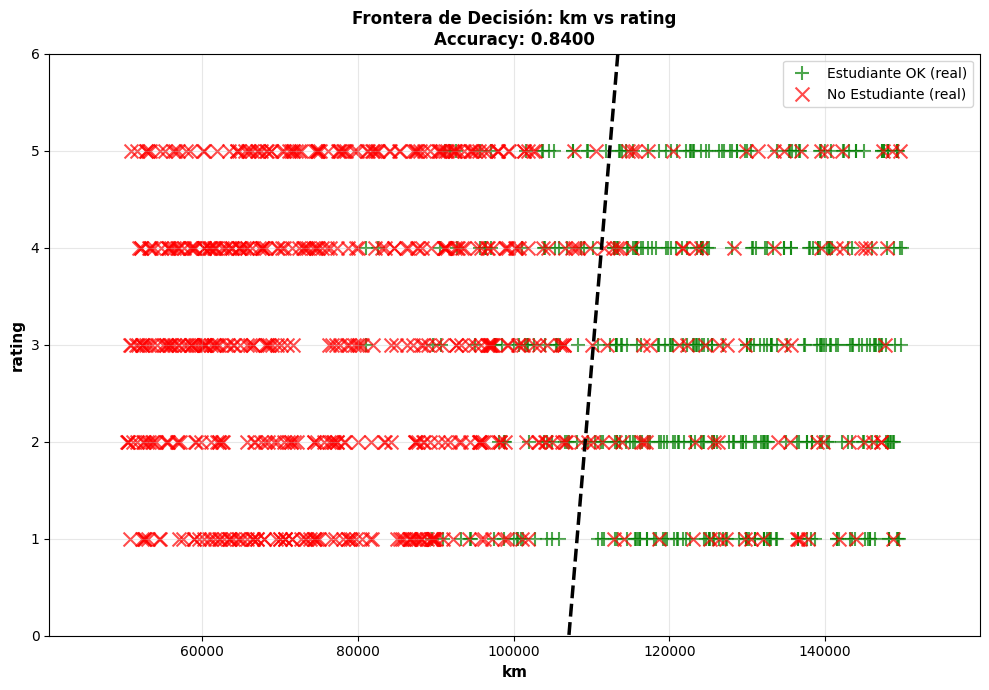


Graficando: economy vs condition
    Frontera graficada correctamente


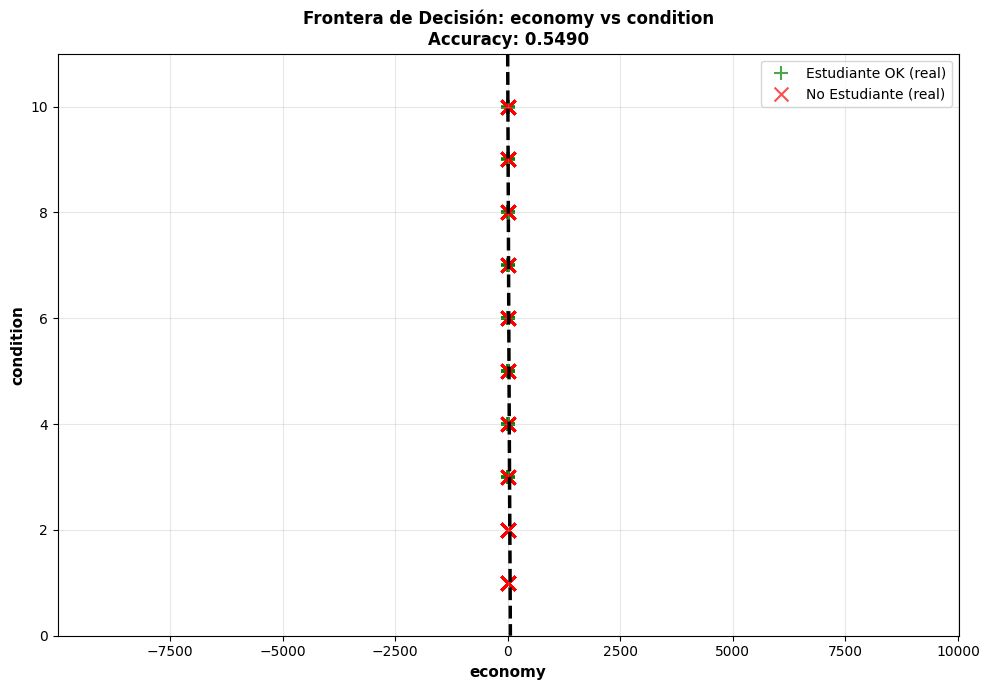


Graficando: economy vs rating
    Frontera graficada correctamente


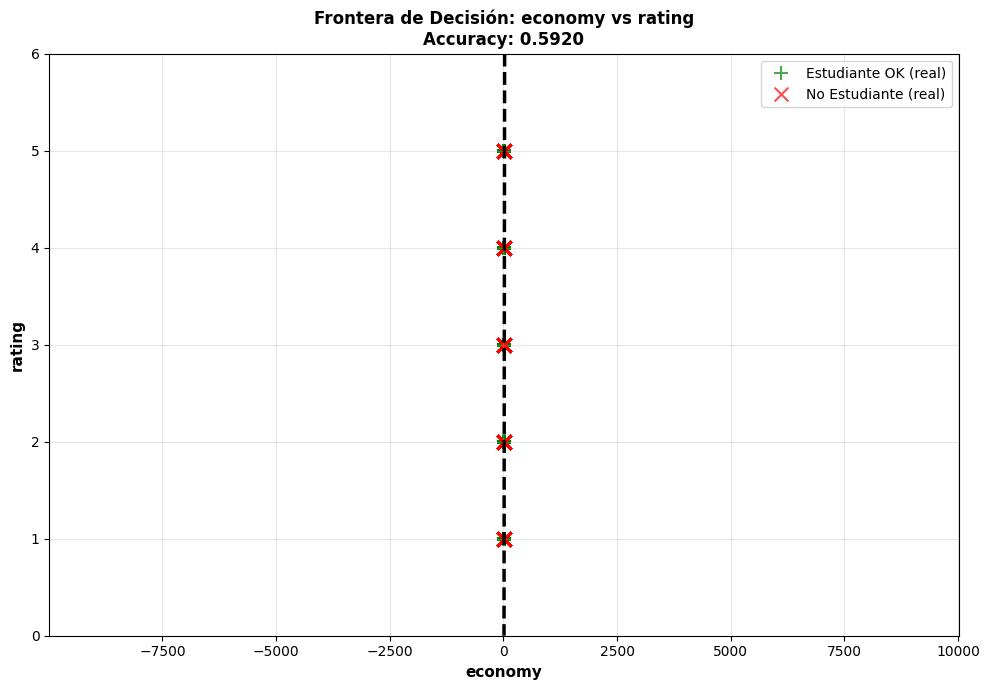


Graficando: condition vs rating
    Frontera graficada correctamente


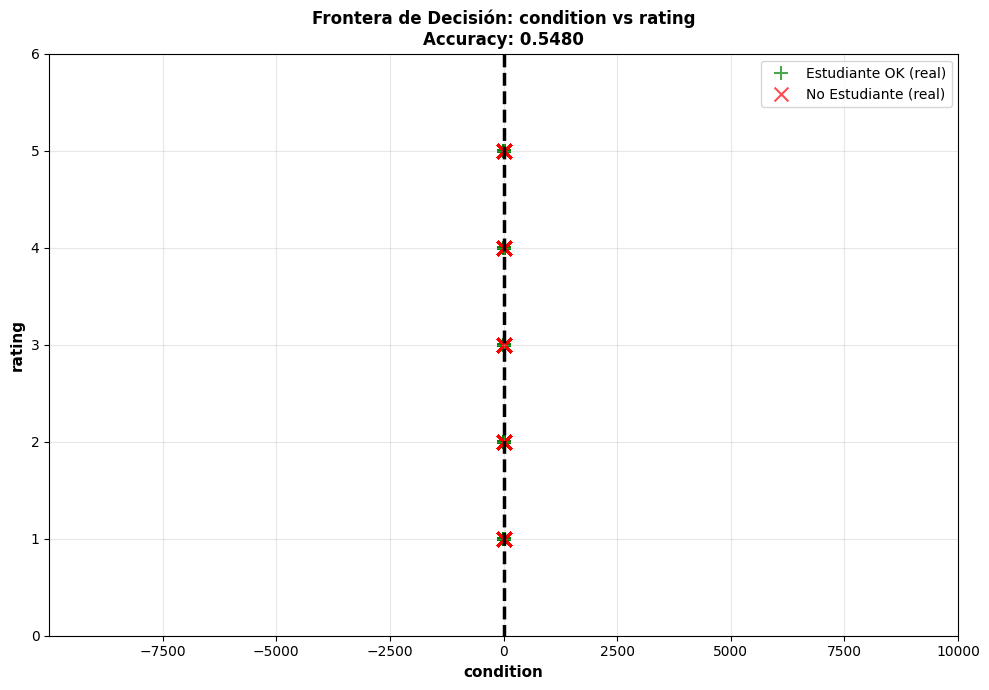

In [21]:
def plot_frontera_decision(par, modelo, X_par_original):
    """Dibuja la frontera de decisión para un par de variables"""
    
    var1, var2 = par
    media = modelo['media']
    desv = modelo['desv']
    theta = modelo['theta']
    
    # Rango de valores para la malla
    min1, max1 = X_par_original[var1].min() - 10000, X_par_original[var1].max() + 10000
    min2, max2 = X_par_original[var2].min() - 1, X_par_original[var2].max() + 1
    
    # Malla de puntos
    xx, yy = np.meshgrid(np.linspace(min1, max1, 300),
                         np.linspace(min2, max2, 300))
    
    # Predecir para cada punto de la malla (VECTORIZADA)
    points_flat = np.column_stack([xx.ravel(), yy.ravel()])
    
    # Normalizar puntos
    points_norm = np.column_stack([
        (points_flat[:, 0] - media[var1]) / desv[var1],
        (points_flat[:, 1] - media[var2]) / desv[var2]
    ])
    
    # Agregar columna de unos y hacer predicción vectorizada
    X_grid = np.column_stack([np.ones(points_norm.shape[0]), points_norm])
    Z_flat = sigmoid(X_grid.dot(theta))
    Z = Z_flat.reshape(xx.shape)
    
    # Crear figura
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Graficar frontera de decisión (contorno en 0.5)
    contour = ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2.5, linestyles='--')
    
    # contour.allsegs[0] accede a los segmentos del primer nivel (0.5 en este caso)
    # Si está vacío, significa que no se encontró ninguna línea de contorno
    if len(contour.allsegs[0]) == 0:
        print(f"         Advertencia: No se encontró contorno claro para {var1} vs {var2}")
        print(f"         Rango de Z: [{Z.min():.4f}, {Z.max():.4f}]")
        print(f"         Esto indica que las clases no son bien separables en este par de variables")
    else:
        print(f"    Frontera graficada correctamente")
    
    # Graficar datos
    df_ok = df[df["estudiante_ok"] == 1]
    df_no = df[df["estudiante_ok"] == 0]
    
    ax.scatter(df_ok[var1], df_ok[var2], c='green', marker='+', s=100, label='Estudiante OK (real)', alpha=0.7)
    ax.scatter(df_no[var1], df_no[var2], c='red', marker='x', s=100, label='No Estudiante (real)', alpha=0.7)
    
    # Labels y título
    ax.set_xlabel(var1, fontsize=11, fontweight='bold')
    ax.set_ylabel(var2, fontsize=11, fontweight='bold')
    accuracy = modelo['accuracy']
    ax.set_title(f'Frontera de Decisión: {var1} vs {var2}\nAccuracy: {accuracy:.4f}', 
                 fontsize=12, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Visualizar fronteras para todos los pares
print("\n" + "="*80)
print("VISUALIZACIÓN DE FRONTERAS DE DECISIÓN")
print("="*80)

for par, modelo in resultados_modelos.items():
    X_par_original = df[[par[0], par[1]]].copy()
    print(f"\nGraficando: {par[0]} vs {par[1]}")
    plot_frontera_decision(par, modelo, X_par_original)

#### Frontera de decisión: `price` vs `km`
Distribución:
- Los estudiantes tienden a tener vehículos más baratos y con más kilómetros (zona inferior izquierda).
- Los no estudiantes se concentran en vehículos más caros y menos usados (zona superior derecha).

Frontera de decisión:
- Separa bastante bien ambas clases, aunque hay algunos errores de clasificación (puntos mal ubicados respecto a la frontera).

#### Frontera de decisión: `price` vs `economy`
Distribución:
- Los estudiantes tienden a tener vehículos más baratos (a la izquierda de la línea).
- Los no estudiantes se concentran en precios más altos (a la derecha).
- La variable economy no parece influir directamente en la frontera, lo que sugiere que el modelo no la está aprovechando bien.

Frontera decisión:
- Esto indica que el modelo ha aprendido que el precio es el principal discriminador, ignorando economy.

#### Frontera de decisión: `price` vs `condition`
Distribución:
- Los estudiantes tienden a tener vehículos más baratos y en peor condición.
- Los no estudiantes se concentran en vehículos más caros y en mejor estado.

Frontera de decisión:
- Tiene una pendiente clara, lo que indica que ambas variables están siendo utilizadas por el modelo para la clasificación.
- Esto sugiere que el modelo ha captado una relación conjunta entre price y condition.

#### Frontera de decisión: `price` vs `rating`
Distribución:
- Los estudiantes tienden a tener vehículos más baratos y con valoraciones más bajas.
- Los no estudiantes se concentran en vehículos más caros y con mejores valoraciones.

Frontera de decisión:
- Tiene una pendiente clara, lo que indica que ambas variables están siendo utilizadas por el modelo.
- La frontera no es vertical ni horizontal, lo que sugiere que el modelo ha captado una relación conjunta entre price y rating.

#### Frontera de decisión: `km` vs `economy`
Distribución:
- Los estudiantes tienden a tener vehículos más usados (más km) y menos eficientes.
- Los no estudiantes se concentran en vehículos más nuevos (menos km) y más eficientes.

Frontera de decisión:
- Tiene una pendiente clara, lo que indica que ambas variables están siendo utilizadas por el modelo.
- La separación entre clases es bastante definida, aunque hay algunos puntos mal clasificados.

#### Frontera de decisión: `km` vs `condition`
Distribución:
- Los estudiantes tienden a tener vehículos más usados (más km) y en peor estado.
- Los no estudiantes se concentran en vehículos más nuevos y en mejor condición.

Frontera de decisión:
- Tiene una pendiente clara, lo que indica que ambas variables están siendo utilizadas por el modelo.
- La separación entre clases es bastante definida, aunque hay algunos puntos mal clasificados.

#### Frontera de decisión: `km` vs `rating`
Distribución:
- Los estudiantes tienden a tener vehículos más usados (más km) y con valoraciones más bajas.
- Los no estudiantes se concentran en vehículos más nuevos y mejor valorados.

Frontera de decisión:
- Tiene una pendiente clara, lo que indica que ambas variables están siendo utilizadas por el modelo.
- La separación entre clases es razonable, aunque hay algunos puntos mal clasificados.

#### Frontera de decisión: `economy` vs `condition`
Distribución:
- Todos los puntos están alineados en economy = 0, lo que sugiere que no hay variación real en esa variable.
- La variable condition sí muestra dispersión, pero no está siendo utilizada por el modelo para la clasificación.

Frontera vertical:
- El modelo ha aprendido una frontera trivial, probablemente por falta de información útil en economy.

##### Frontera de decisión: `economy` vs `rating`
Distribución:
- Todos los puntos están alineados en economy = 0, lo que indica que no hay variabilidad en esa variable.
- La variable rating sí muestra dispersión vertical, pero no está siendo utilizada para definir la frontera.

Frontera vertical:
- El modelo ha aprendido una frontera trivial, probablemente por defecto, debido a la falta de información útil en economy.

##### Frontera de decisión: `condition` vs `rating`
Distribución:
- Todos los puntos están alineados en condition = 0, lo que indica que no hay variabilidad en esa variable.
- La variable rating sí muestra dispersión vertical, pero no está siendo utilizada para definir la frontera.

Frontera vertical:
- El modelo ha aprendido una frontera trivial, probablemente por defecto, debido a la falta de información útil en condition.

---
#### 10.4 Análisis de correlación entre variables



ANÁLISIS DE CORRELACIÓN ENTRE PARES DE VARIABLES

price - km: -0.9359
  -> Correlación FUERTE

price - economy: -0.0347
  -> Correlación DÉBIL

price - condition: 0.1101
  -> Correlación DÉBIL

price - rating: 0.0350
  -> Correlación DÉBIL

km - economy: 0.0327
  -> Correlación DÉBIL

km - condition: -0.0136
  -> Correlación DÉBIL

km - rating: -0.0399
  -> Correlación DÉBIL

economy - condition: 0.0588
  -> Correlación DÉBIL

economy - rating: -0.0098
  -> Correlación DÉBIL

condition - rating: 0.0159
  -> Correlación DÉBIL


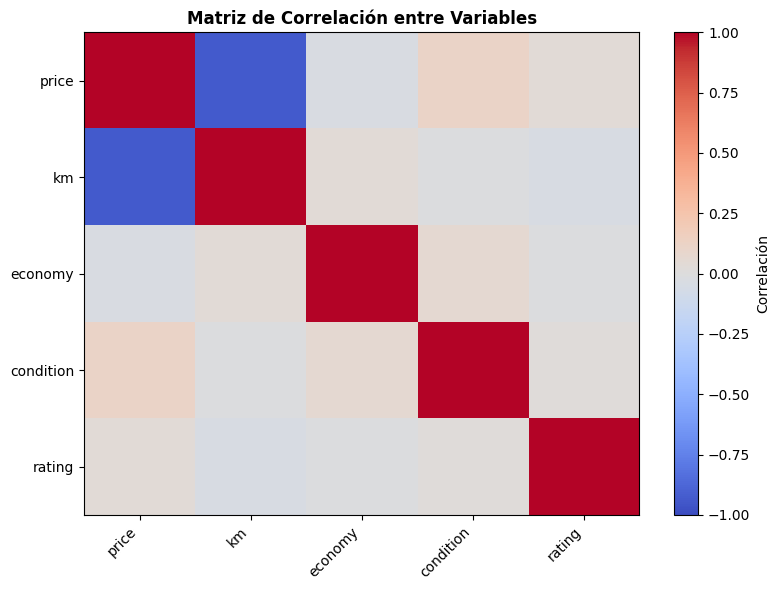

In [22]:
print("\n" + "="*80)
print("ANÁLISIS DE CORRELACIÓN ENTRE PARES DE VARIABLES")
print("="*80)

for par in pares_variables:
    var1, var2 = par
    correlacion = df[var1].corr(df[var2])
    print(f"\n{var1} - {var2}: {correlacion:.4f}")
    
    # Interpretación
    if abs(correlacion) > 0.7:
        print("  -> Correlación FUERTE")
    elif abs(correlacion) > 0.4:
        print("  -> Correlación MODERADA")
    else:
        print("  -> Correlación DÉBIL")
# Heatmap de correlaciones
plt.figure(figsize=(8, 6))
corr_matrix = df[variables_analisis].corr()
plt.imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
plt.colorbar(label='Correlación')
plt.xticks(range(len(variables_analisis)), variables_analisis, rotation=45, ha='right')
plt.yticks(range(len(variables_analisis)), variables_analisis)
plt.title('Matriz de Correlación entre Variables', fontweight='bold')
plt.tight_layout()
plt.show()


In [23]:
print("\n" + "="*80)
print("COMPARATIVA: ANÁLISIS UNIVARIABLE vs MODELO COMPLETO")
print("="*80)

# Recopilar resultados del modelo completo (5 variables)
print("\nMODELO COMPLETO (5 variables: price, km, economy, condition, rating)")
print("-" * 80)
print(f"Accuracy:  {accuracy_full:.4f}")
print(f"Precisión: {TP / (TP + FP) if (TP + FP) > 0 else 0:.4f}")
print(f"Recall:    {TP / (TP + FN) if (TP + FN) > 0 else 0:.4f}")
print(f"TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")

# Mejores modelos por pares
print("\n\nTOP 5 MEJORES MODELOS POR PARES DE VARIABLES")
print("-" * 80)

modelos_ordenados = sorted(resultados_modelos.items(), 
                           key=lambda x: x[1]['accuracy'], 
                           reverse=True)

for i, (par, modelo) in enumerate(modelos_ordenados[:5], 1):
    var1, var2 = par
    print(f"\n{i}. {var1} vs {var2}")
    print(f"   Accuracy:  {modelo['accuracy']:.4f}")
    print(f"   Precisión: {modelo['precision']:.4f}")
    print(f"   Recall:    {modelo['recall']:.4f}")
    print(f"   F1-Score:  {modelo['f1']:.4f}")
    print(f"   Matriz confusión -> TP:{modelo['TP']}, TN:{modelo['TN']}, FP:{modelo['FP']}, FN:{modelo['FN']}")

# Análisis comparativo
print("\n\nCONCLUSIONES DEL ANÁLISIS")
print("-" * 80)

mejor_accuracy_pares = modelos_ordenados[0][1]['accuracy']
diferencia = accuracy_full - mejor_accuracy_pares

print(f"\nAccuracy del modelo completo:        {accuracy_full:.4f}")
print(f"Accuracy del mejor par de variables: {mejor_accuracy_pares:.4f}")
print(f"Diferencia:                          {diferencia:.4f} ({diferencia*100:.2f}%)")

if diferencia > 0:
    print(f"\nEl modelo completo es MEJOR que cualquier par individual")
    print(f"  Las 5 variables aportan información complementaria")
else:
    print(f"\nEl mejor par de variables es comparable al modelo completo")
    print(f"  Posible reducción de dimensionalidad sin pérdida significativa")

# Variables más importantes según correlación
print("\n\nVARIABLES MÁS CORRELACIONADAS CON LA CLASE 'estudiante_ok'")
print("-" * 80)

correlaciones_clase = []
for var in variables_analisis:
    corr = df[var].corr(df['estudiante_ok'])
    correlaciones_clase.append((var, corr))

correlaciones_clase.sort(key=lambda x: abs(x[1]), reverse=True)

for var, corr in correlaciones_clase:
    print(f"{var:12s}: {corr:7.4f}")



COMPARATIVA: ANÁLISIS UNIVARIABLE vs MODELO COMPLETO

MODELO COMPLETO (5 variables: price, km, economy, condition, rating)
--------------------------------------------------------------------------------
Accuracy:  0.8560
Precisión: 0.8350
Recall:    0.8064
TP: 329, TN: 527, FP: 65, FN: 79


TOP 5 MEJORES MODELOS POR PARES DE VARIABLES
--------------------------------------------------------------------------------

1. price vs condition
   Accuracy:  0.8540
   Precisión: 0.8243
   Recall:    0.8162
   F1-Score:  0.8202
   Matriz confusión -> TP:333, TN:521, FP:71, FN:75

2. km vs condition
   Accuracy:  0.8470
   Precisión: 0.8133
   Recall:    0.8113
   F1-Score:  0.8123
   Matriz confusión -> TP:331, TN:516, FP:76, FN:77

3. price vs km
   Accuracy:  0.8460
   Precisión: 0.8128
   Recall:    0.8088
   F1-Score:  0.8108
   Matriz confusión -> TP:330, TN:516, FP:76, FN:78

4. price vs rating
   Accuracy:  0.8450
   Precisión: 0.8123
   Recall:    0.8064
   F1-Score:  0.8093
   Matriz